# Bayesian Decision based on Gaussian 

16307110216 Ruian He

### Extract data from downloaded files

As the data is stored in bytes, we need to follow the strcture of the files to extract.

In [1]:
import numpy as np
import gzip,struct,os


'''
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
'''

def extract_image(file_path):
    print("Extracting:",file_path)
    with gzip.GzipFile(fileobj=open(file_path,mode='rb')) as buf:
        magic,num,row,col = struct.unpack('>4I',buf.read(4*4))
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %(magic, file_path))
        image = np.frombuffer(buf.read(num*row*col), dtype=np.uint8)
        return image.reshape(num,row,col).astype(int)
    
'''
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label
'''
    
def extract_label(file_path):
    print("Extracting:",file_path)
    with gzip.GzipFile(fileobj=open(file_path,mode='rb')) as buf:
        magic,num = struct.unpack('>2I',buf.read(2*4))
        if magic != 2049:
            raise ValueError('Invalid magic number %d in MNIST label file: %s' %(magic, file_path))
        label = np.frombuffer(buf.read(num), dtype=np.uint8)
        return label.astype(int)

Then we do the above approaches on our MNIST dataset.

In [2]:
data_dir = '../minist'

train_image_file = "train-images-idx3-ubyte.gz"
train_label_file = "train-labels-idx1-ubyte.gz"
test_image_file = "t10k-images-idx3-ubyte.gz"
test_label_file = "t10k-labels-idx1-ubyte.gz"

X_train = extract_image(os.path.join(data_dir,train_image_file))
print('Training data shape: ', X_train.shape)
y_train = extract_label(os.path.join(data_dir,train_label_file))
print('Training labels shape: ', y_train.shape)
X_test = extract_image(os.path.join(data_dir,test_image_file))
print('Test data shape: ', X_test.shape)
y_test = extract_label(os.path.join(data_dir,test_label_file))
print('Test labels shape: ', y_test.shape)

Extracting: ../minist/train-images-idx3-ubyte.gz
Training data shape:  (60000, 28, 28)
Extracting: ../minist/train-labels-idx1-ubyte.gz
Training labels shape:  (60000,)
Extracting: ../minist/t10k-images-idx3-ubyte.gz
Test data shape:  (10000, 28, 28)
Extracting: ../minist/t10k-labels-idx1-ubyte.gz
Test labels shape:  (10000,)


### Visualize and Preprocess the data

First of all, we are interested in how the dataset looks like and whether it is valid.

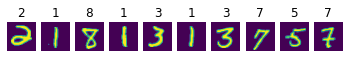

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

choice = np.random.choice(X_test.shape[0],10)
random_image = X_test[choice]
random_label = y_test[choice]

fig,ax = plt.subplots(1,10)
for i in range(10):
    ax[i].set_title(random_label[i])
    ax[i].imshow(random_image[i])
    ax[i].axis('off')

Because the bayesian model need binarized images, so we choose a threshold that pixels whose values are above the threshold will be mark 1 or otherwise 0.

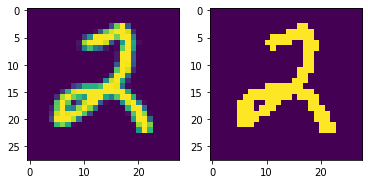

In [4]:
threshold = 128

X_train_binarized = X_train > threshold
X_test_binarized  = X_test  > threshold

choice = np.random.choice(X_test.shape[0])

fig,ax = plt.subplots(1,2)
ax[0].imshow(X_train[choice])
ax[1].imshow(X_train_binarized[choice])

### Bayesian Decision Model

Next, we start to build Bayesian Decision model from scratch.For training, we extract the prior and the likelihood from training set.The prior is extactly the frequency that every digit occurs, while the likelihood is the frequency that every pixel appears in a specified digit.

For prediction, we use bayesian decision formula posterior = likelihood * prior / evidence and use log on both sides. As we only need to compare the relative size, we can ignore that evidence which is the same for all posteriors. Then the final one is log(prior) + sum(log(likelihood)).

In [23]:
class BayesianDecision(object):
    def __init__(self):
        self.eps = 1e-5

    # extract prior and likelihood
    def train(self, X, y):
        self.prior = np.bincount(y)/y.shape[0]
        self.likelihood = np.zeros((10, X.shape[1]))
        for i in range(10):
            self.likelihood[i] = np.sum(X[np.where(y == i)],axis=0)
        
    # Predict test set
    def predict(self, X):
        posterior = np.zeros((10,X.shape[0]))
        for i in range(10):
            posterior[i] = np.sum(np.log(X * self.likelihood[i]+self.eps),axis = 1)
        posterior = (posterior.T + np.log(self.prior+self.eps)).T
        return np.argmax(posterior,axis=0)

### Train the model

Now we get the model and the data,then we can start training and testing.

In [24]:
# first reshape train data to fit matrix calculus
X_train_binarized = np.reshape(X_train_binarized, (X_train_binarized.shape[0], -1))
X_test_binarized  = np.reshape(X_test_binarized,  (X_test_binarized.shape[0],  -1))
print(X_train_binarized.shape, X_test_binarized.shape)

model = BayesianDecision()
model.train(X_train_binarized,y_train)

y_pred = model.predict(X_test_binarized)
accuracy = np.sum(y_test == y_pred)/y_test.shape[0]
print("The accuracy is:",accuracy)

(60000, 784) (10000, 784)
The accuracy is: 0.7232
